In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
from poola import core as pool
import anchors

import core_functions as fns

gpp.set_aesthetics(palette='Set2')

In [4]:
def run_guide_residuals(lfc_df, paired_lfc_cols=[]):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Inputs:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    2. paired_lfc_cols: grouped list of initial populations and corresponding resistant populations 
    
    '''
    lfc_df = lfc_df.drop_duplicates()
    if not paired_lfc_cols:
        paired_lfc_cols = fns.pair_cols(lfc_df)[1] #get lfc pairs 
    modified = []
    unperturbed = []
    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    
    print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots

def select_top_ranks(df, rank = 5, largest=True): #pick top ranks from each column of df with ranks, rank = top rank threshold (e.g. 5 if top 5)
    '''
    Inputs: 
    1. df: Dataframe with columns "Gene Symbol" and data used to rank 
    2. rank: top number of rows to select 
    Outputs:
    1. final_top_rank_df: Data frame with top ranked rows 
    '''
    rank_cols = df.columns.to_list()[1:]
    prev_top_rank_rows = pd.DataFrame(columns = df.columns)
    final_top_rank_df = pd.DataFrame() #for final list
    for col in rank_cols:
        #top_rank_rows = df.copy().loc[lambda df: df[col] <= rank, :] #pick rows with rank <= 5
        if largest:
            top_rank_rows = df.copy().nlargest(rank, col)
        else:
            top_rank_rows = df.copy().nsmallest(rank, col)
        top_rank_df = pd.concat([prev_top_rank_rows, top_rank_rows]) #concat with rows selected from previous column
        prev_top_rank_rows = top_rank_df #set combined list as previous

    final_top_rank_df = prev_top_rank_rows.drop_duplicates(subset = ['Gene Symbol']) #drop duplicate gene rows
    return final_top_rank_df


# A549 (ACE2)

**Cell line**: A549 overexpressing ACE2 <br/>
**Library**: Secondary CRISPRa library 

## Data summary
 

In [3]:
# Reads from Supplemental File 13
reads = pd.read_excel('Data/GSE193834_Supplementary_Data_13_A549-ACE2_Act_SecondaryLibrary_Goujon.xlsx', sheet_name = 'A549_genomewide_reads')
reads



,Construct Barcode,pDNA,A549-CP1663-initial population screen #1,A549-CP1663-resistant population screen #1,A549-CP1663-initial population screen #2,A549-CP1663-resistant population screen #2
0,AAAAAAAAAAAAAATTGGCC,11,1139,1281,687,738
1,AAAAAAAAATTGGCCAGGCG,28,3445,6959,2685,2595
2,AAAAAAAGTTGTGCGAGCGA,45,4589,4716,3380,4355
3,AAAAAAGAAAATAAGTTCCC,28,1704,1423,1666,1528
4,AAAAAAGTTGTGCGAGCGAC,70,5178,12443,5306,5705
...,...,...,...,...,...,...
4996,TTTGGAGTGATATTCGAACA,51,4471,8412,4588,5016
4997,TTTGGCAGTCTATTACGGTA,62,6576,5344,6934,6984
4998,TTTGGTGTGGCCGTCGCGCA,30,1107,2326,1322,1142
4999,TTTGTGGGCCATTTAATTCA,52,8235,15119,10047,11914


In [8]:
# Gene Annotations
chip = pd.read_excel('Data/GSE193834_Supplementary_Data_13_A549-ACE2_Act_SecondaryLibrary_Goujon.xlsx', sheet_name = 'A549_guide_mapping')

# Merge annotations with reads
chip_reads = pd.merge(chip[['Construct Barcode', 'Gene Symbol']], reads, on = ['Construct Barcode'], how = 'right')
chip_reads


,Construct Barcode,Gene Symbol,pDNA,A549-CP1663-initial population screen #1,A549-CP1663-resistant population screen #1,A549-CP1663-initial population screen #2,A549-CP1663-resistant population screen #2
0,AAAAAAAAAAAAAATTGGCC,IQCN,11,1139,1281,687,738
1,AAAAAAAAAAAAAATTGGCC,LOC101929974,11,1139,1281,687,738
2,AAAAAAAAATTGGCCAGGCG,IQCN,28,3445,6959,2685,2595
3,AAAAAAAGTTGTGCGAGCGA,GDI2,45,4589,4716,3380,4355
4,AAAAAAGAAAATAAGTTCCC,DBR1,28,1704,1423,1666,1528
...,...,...,...,...,...,...,...
5847,TTTGGAGTGATATTCGAACA,ONE_INTERGENIC_SITE_10,51,4471,8412,4588,5016
5848,TTTGGCAGTCTATTACGGTA,ONE_INTERGENIC_SITE_43,62,6576,5344,6934,6984
5849,TTTGGTGTGGCCGTCGCGCA,LYN,30,1107,2326,1322,1142
5850,TTTGTGGGCCATTTAATTCA,EEF1B2,52,8235,15119,10047,11914


In [9]:
#Calculate lognorm
cols = chip_reads.columns[2:].to_list() #reads columns = start at 3rd column
lognorms = fns.get_lognorm(chip_reads.dropna(), cols = cols)
col_list = []

for col in lognorms.columns:
    if 'intitial'in col:
        new_col = col.replace('intitial', 'initial')
        col_list.append(new_col)
    else:
        col_list.append(col)

lognorms.columns = col_list
lognorms

,Construct Barcode,Gene Symbol,pDNA_lognorm,A549-CP1663-initial population screen #1_lognorm,A549-CP1663-resistant population screen #1_lognorm,A549-CP1663-initial population screen #2_lognorm,A549-CP1663-resistant population screen #2_lognorm
0,AAAAAAAAAAAAAATTGGCC,IQCN,5.731072,5.774091,5.783318,5.049974,5.028132
1,AAAAAAAAAAAAAATTGGCC,LOC101929974,5.731072,5.774091,5.783318,5.049974,5.028132
2,AAAAAAAAATTGGCCAGGCG,IQCN,7.062410,7.353071,8.203394,6.983738,6.810183
3,AAAAAAAGTTGTGCGAGCGA,GDI2,7.742824,7.764545,7.644404,7.313493,7.551916
4,AAAAAAGAAAATAAGTTCCC,DBR1,7.062410,6.346480,5.932367,6.302159,6.055042
...,...,...,...,...,...,...,...
5847,TTTGGAGTGATATTCGAACA,ONE_INTERGENIC_SITE_10,7.922604,7.727138,8.476117,7.751945,7.754767
5848,TTTGGCAGTCTATTACGGTA,ONE_INTERGENIC_SITE_43,8.203320,8.281570,7.823913,8.345502,8.230400
5849,TTTGGTGTGGCCGTCGCGCA,LYN,7.161226,5.733740,6.632082,5.973243,5.642276
5850,TTTGTGGGCCATTTAATTCA,EEF1B2,7.950504,8.605194,9.320161,8.879132,8.998943


## Quality Control
### Population Distributions

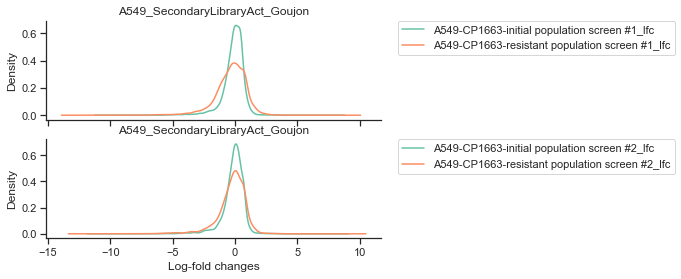

In [10]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[3:])
pDNA_lfc = fns.calculate_lfc(lognorms,target_cols)
pDNA_lfc
pair1 = list(pDNA_lfc.columns[2:4])
pair2 = list(pDNA_lfc.columns[4:])
paired_cols = (True, [pair1, pair2])
#Plot population distributions of log-fold changes 
fns.lfc_dist_plot(pDNA_lfc, paired_cols=paired_cols, filename = 'A549_SecondaryLibraryAct_Goujon')


### Distributions of control sets 

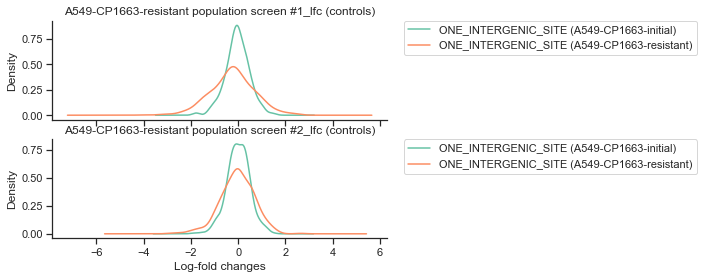

In [11]:
fns.control_dist_plot(pDNA_lfc, paired_cols=paired_cols, control_name=['ONE_INTERGENIC_SITE'], filename = 'A549_SecondaryLibraryAct_Goujon')


### ROC_AUC

Essential gene set: Hart et al., 2015 
<br>
Non-essential gene set: Hart et al., 2014 
<br>
AUC expected to be ~0.5 because no cutting occurred

Text(0, 0.5, 'True Positive Rate (essential)')

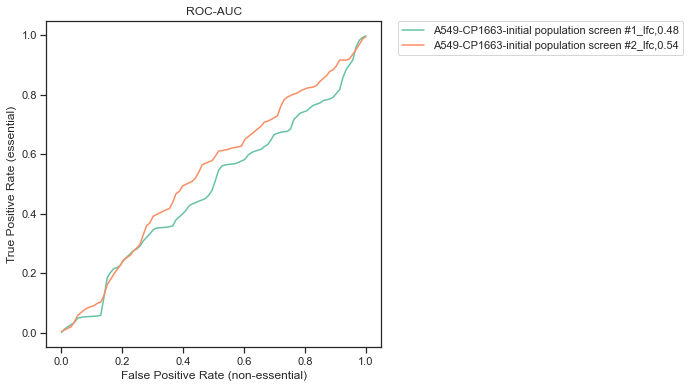

In [14]:
ess_genes, non_ess_genes = fns.get_gene_sets()
initial_cols = [col for col in pDNA_lfc.columns if 'initial' in col]

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

initial_roc_dict = {}
intial_roc_auc_dict = {}
for col in initial_cols:
    roc_auc, roc_df = pool.get_roc_aucs(pDNA_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col=col)
    initial_roc_dict[col] = roc_df
    intial_roc_auc_dict[col] = roc_auc

fig,ax=plt.subplots(figsize=(6,6))

for key, df in initial_roc_dict.items():
    roc_auc = intial_roc_auc_dict[key]
    ax=sns.lineplot(data=df, x='fpr',y='tpr', ci=None, label = key+',' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene level analysis

### Residual z-scores

In [15]:
lfc_df = pDNA_lfc.drop('Gene Symbol', axis = 1)
lfc_df

,Construct Barcode,A549-CP1663-initial population screen #1_lfc,A549-CP1663-resistant population screen #1_lfc,A549-CP1663-initial population screen #2_lfc,A549-CP1663-resistant population screen #2_lfc
0,AAAAAAAAAAAAAATTGGCC,0.043019,0.052246,-0.681098,-0.702940
1,AAAAAAAAAAAAAATTGGCC,0.043019,0.052246,-0.681098,-0.702940
2,AAAAAAAAATTGGCCAGGCG,0.290661,1.140985,-0.078672,-0.252227
3,AAAAAAAGTTGTGCGAGCGA,0.021721,-0.098420,-0.429331,-0.190909
4,AAAAAAGAAAATAAGTTCCC,-0.715929,-1.130043,-0.760250,-1.007368
...,...,...,...,...,...
5847,TTTGGAGTGATATTCGAACA,-0.195466,0.553513,-0.170659,-0.167837
5848,TTTGGCAGTCTATTACGGTA,0.078250,-0.379407,0.142182,0.027080
5849,TTTGGTGTGGCCGTCGCGCA,-1.427486,-0.529144,-1.187983,-1.518950
5850,TTTGTGGGCCATTTAATTCA,0.654690,1.369657,0.928628,1.048439


In [16]:
# run_guide_residuals(lfc_df.drop_duplicates(), cols)
residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_df, paired_lfc_cols=paired_cols[1])
residuals_lfcs


                                         modified  \
0  A549-CP1663-resistant population screen #1_lfc   
1  A549-CP1663-resistant population screen #2_lfc   

                                    unperturbed  
0  A549-CP1663-initial population screen #1_lfc  
1  A549-CP1663-initial population screen #2_lfc  


,Construct Barcode,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAAAAAAAATTGGCC,A549-CP1663-resistant population screen #1_lfc,0.219910,0.290726,A549-CP1663-initial population screen #1_lfc,0.052246,0.043019
1,AAAAAAAAATTGGCCAGGCG,A549-CP1663-resistant population screen #1_lfc,1.004033,1.327353,A549-CP1663-initial population screen #1_lfc,1.140985,0.290661
2,AAAAAAAGTTGTGCGAGCGA,A549-CP1663-resistant population screen #1_lfc,0.095788,0.126634,A549-CP1663-initial population screen #1_lfc,-0.098420,0.021721
3,AAAAAAGAAAATAAGTTCCC,A549-CP1663-resistant population screen #1_lfc,-0.021457,-0.028366,A549-CP1663-initial population screen #1_lfc,-1.130043,-0.715929
4,AAAAAAGTTGTGCGAGCGAC,A549-CP1663-resistant population screen #1_lfc,1.431794,1.892862,A549-CP1663-initial population screen #1_lfc,0.661771,-0.439841
...,...,...,...,...,...,...,...
9997,TTTGGAGTGATATTCGAACA,A549-CP1663-resistant population screen #2_lfc,0.120803,0.239328,A549-CP1663-initial population screen #2_lfc,-0.167837,-0.170659
9998,TTTGGCAGTCTATTACGGTA,A549-CP1663-resistant population screen #2_lfc,-0.064841,-0.128459,A549-CP1663-initial population screen #2_lfc,0.027080,0.142182
9999,TTTGGTGTGGCCGTCGCGCA,A549-CP1663-resistant population screen #2_lfc,0.110496,0.218908,A549-CP1663-initial population screen #2_lfc,-1.518950,-1.187983
10000,TTTGTGGGCCATTTAATTCA,A549-CP1663-resistant population screen #2_lfc,0.097092,0.192354,A549-CP1663-initial population screen #2_lfc,1.048439,0.928628


In [17]:
guide_mapping = pool.group_pseudogenes(chip[['Construct Barcode', 'Gene Symbol']], pseudogene_size=10, gene_col='Gene Symbol', control_regex=['ONE_INTERGENIC_SITE'])
guide_mapping

,Construct Barcode,Gene Symbol
0,AAAAAAAAAAAAAATTGGCC,IQCN
1,AAAAAAAAAAAAAATTGGCC,LOC101929974
2,AAAAAAAAATTGGCCAGGCG,IQCN
3,AAAAAAAGTTGTGCGAGCGA,GDI2
4,AAAAAAGAAAATAAGTTCCC,DBR1
...,...,...
5847,TTTGGAGTGATATTCGAACA,ONE_INTERGENIC_SITE_10
5848,TTTGGCAGTCTATTACGGTA,ONE_INTERGENIC_SITE_43
5849,TTTGGTGTGGCCGTCGCGCA,LYN
5850,TTTGTGGGCCATTTAATTCA,EEF1B2


In [18]:
A549_gene_residuals = anchors.get_gene_residuals(residuals_lfcs.drop_duplicates(), guide_mapping)
A549_gene_residuals

,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,A549-CP1663-resistant population screen #1_lfc,ABHD17B,1,-0.972568,-0.221866,-0.626059,0.531276,0.780683
1,A549-CP1663-resistant population screen #1_lfc,ABRACL,10,-0.281008,0.051611,-0.511243,0.609181,0.794693
2,A549-CP1663-resistant population screen #1_lfc,ACADSB,20,-0.432766,-0.139665,-0.233039,0.815731,0.918818
3,A549-CP1663-resistant population screen #1_lfc,ACE,10,0.387920,0.341222,0.869656,0.384489,0.780683
4,A549-CP1663-resistant population screen #1_lfc,ACE2,10,-0.926470,-0.080355,-2.507902,0.012145,0.399763
...,...,...,...,...,...,...,...,...
1635,A549-CP1663-resistant population screen #2_lfc,ZNF626,1,0.234784,0.759939,-1.054882,0.291479,0.982751
1636,A549-CP1663-resistant population screen #2_lfc,ZNF703,10,-0.308310,-0.155308,-0.075699,0.939659,0.982751
1637,A549-CP1663-resistant population screen #2_lfc,ZNF780A,10,0.126738,0.135186,0.530746,0.595595,0.982751
1638,A549-CP1663-resistant population screen #2_lfc,ZNF805,10,-0.400576,-0.167336,-0.412643,0.679868,0.982751


Average across resistant screens and apply guide filter

In [19]:
A549_gene_residual_sheet = fns.format_gene_residuals(A549_gene_residuals, guide_min = 8, guide_max = 11, ascending=True)

guide_residual_sheet = pd.merge(guide_mapping, residuals_lfcs.drop_duplicates(), on = 'Construct Barcode', how = 'inner')
guide_residual_sheet

['A549-CP1663-resistant population screen #2_lfc', 'A549-CP1663-resistant population screen #1_lfc']
A549-CP1663-resistant population screen #2_lfc
A549-CP1663-resistant population screen #1_lfc


,Construct Barcode,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAAAAAAAATTGGCC,IQCN,A549-CP1663-resistant population screen #1_lfc,0.219910,0.290726,A549-CP1663-initial population screen #1_lfc,0.052246,0.043019
1,AAAAAAAAAAAAAATTGGCC,IQCN,A549-CP1663-resistant population screen #2_lfc,0.267627,0.530208,A549-CP1663-initial population screen #2_lfc,-0.702940,-0.681098
2,AAAAAAAAAAAAAATTGGCC,LOC101929974,A549-CP1663-resistant population screen #1_lfc,0.219910,0.290726,A549-CP1663-initial population screen #1_lfc,0.052246,0.043019
3,AAAAAAAAAAAAAATTGGCC,LOC101929974,A549-CP1663-resistant population screen #2_lfc,0.267627,0.530208,A549-CP1663-initial population screen #2_lfc,-0.702940,-0.681098
4,AAAAAAAAATTGGCCAGGCG,IQCN,A549-CP1663-resistant population screen #1_lfc,1.004033,1.327353,A549-CP1663-initial population screen #1_lfc,1.140985,0.290661
...,...,...,...,...,...,...,...,...
11699,TTTGGTGTGGCCGTCGCGCA,LYN,A549-CP1663-resistant population screen #2_lfc,0.110496,0.218908,A549-CP1663-initial population screen #2_lfc,-1.518950,-1.187983
11700,TTTGTGGGCCATTTAATTCA,EEF1B2,A549-CP1663-resistant population screen #1_lfc,0.802836,1.061367,A549-CP1663-initial population screen #1_lfc,1.369657,0.654690
11701,TTTGTGGGCCATTTAATTCA,EEF1B2,A549-CP1663-resistant population screen #2_lfc,0.097092,0.192354,A549-CP1663-initial population screen #2_lfc,1.048439,0.928628
11702,TTTGTTTAAATAGCACTACA,OR8K5,A549-CP1663-resistant population screen #1_lfc,0.533890,0.705814,A549-CP1663-initial population screen #1_lfc,0.557317,0.197501


In [16]:
# with pd.ExcelWriter('../../../Data/Processed/GEO_submission_v2/SecondaryLibrary/A549_SecondaryLibraryAct_Goujon.xlsx') as writer:  
#     A549_gene_residual_sheet.to_excel(writer, sheet_name='A549_avg_zscore', index =False)
#     reads.to_excel(writer, sheet_name='A549_genomewide_reads', index =False)
#     guide_mapping.to_excel(writer, sheet_name='A549_guide_mapping', index =False)

In [17]:
# with pd.ExcelWriter('../../../Data/Processed/Individual_screens_v2/SecondaryLibraryIndivScreens/A549_SecondaryLibraryAct_Goujon.xlsx') as writer:  
#     A549_gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
#     guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)

### A549 Act Replicate Correlations

In [20]:
A549_screen1_df = A549_gene_residuals[A549_gene_residuals['condition'].str.contains('#1')]
A549_screen2_df = A549_gene_residuals[A549_gene_residuals['condition'].str.contains('#2')]
A549_zscore_df = pd.merge(A549_screen1_df[['Gene Symbol', 'residual_zscore']], A549_screen2_df[['Gene Symbol', 'residual_zscore']], on = 'Gene Symbol', how = 'outer', suffixes = ['_screen#1', '_screen#2'])
A549_zscore_df

,Gene Symbol,residual_zscore_screen#1,residual_zscore_screen#2
0,ABHD17B,-0.626059,1.227702
1,ABRACL,-0.511243,0.253196
2,ACADSB,-0.233039,2.173453
3,ACE,0.869656,-1.157609
4,ACE2,-2.507902,-7.427167
...,...,...,...
815,ZNF626,-0.652211,-1.054882
816,ZNF703,1.020122,-0.075699
817,ZNF780A,2.183611,0.530746
818,ZNF805,0.537889,-0.412643


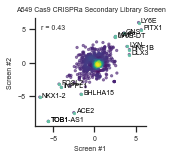

In [22]:
# Screen 2 vs Screen 1

fig, ax = plt.subplots(figsize = (2, 2))
ax = gpp.point_densityplot(A549_zscore_df, 'residual_zscore_screen#1', 'residual_zscore_screen#2', s=6)
ax = gpp.add_correlation(A549_zscore_df, 'residual_zscore_screen#1', 'residual_zscore_screen#2', fontsize=7)

top_ranked_screen1 = A549_zscore_df.nsmallest(5, 'residual_zscore_screen#1')
top_ranked_screen2 = A549_zscore_df.nsmallest(5, 'residual_zscore_screen#2')
bottom_ranked_screen1 = A549_zscore_df.nlargest(5, 'residual_zscore_screen#1')
bottom_ranked_screen2 = A549_zscore_df.nlargest(5, 'residual_zscore_screen#2')

screen1_ranked = pd.concat([top_ranked_screen1, bottom_ranked_screen1])
screen2_ranked = pd.concat([top_ranked_screen2, bottom_ranked_screen2])
ranked = pd.concat([screen1_ranked, screen2_ranked]).drop_duplicates()

# Annotate common hits
# common_ranked = pd.merge(screen1_ranked, screen2_ranked, on = ['Gene Symbol', 'residual_zscore_screen#1', 'residual_zscore_screen#2'], how = 'inner')
# common_ranked

sns.scatterplot(data=ranked, x='residual_zscore_screen#1', y='residual_zscore_screen#2', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, rasterized=True)

texts= []
for j, row in ranked.iterrows():
    texts.append(ax.text(row['residual_zscore_screen#1']+0.25, row['residual_zscore_screen#2'], row['Gene Symbol'], fontsize=7,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

plt.title('A549 Cas9 CRISPRa Secondary Library Screen', fontsize=7)
plt.xlabel('Screen #1', fontsize=7)
plt.ylabel('Screen #2', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
sns.despine()
# gpp.savefig('../../../Figures/Scatterplots/A549_Cas9_Act_Secondary_Screen1vs2_scatterplot.pdf', dpi=300)



### Primary KO vs Cas9 Secondary A549 Act screens

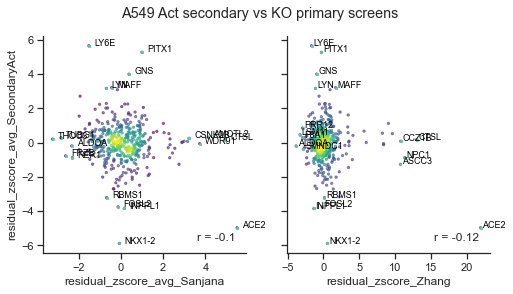

In [25]:
# Reads from Sanjana paper (A549 (ACE2) screened using GeCKOv2)
Cas9_KO_A549_Sanjana_primary = pd.read_excel('../PrimaryScreens/Data/GSE175666_A549_GeCKOv2_Sanjana_v2.xlsx')

# Reads from Zhang paper (A549 (ACE2) screened using Brunello)
Cas9_KO_A549_Zhang_primary = pd.read_excel('../PrimaryScreens/Data/GSE175666_A549_Brunello_Zhang.xlsx')

Cas9_KO_A549_primary = pd.merge(Cas9_KO_A549_Sanjana_primary, Cas9_KO_A549_Zhang_primary, on = 'Gene Symbol', how = 'outer')
Cas9_KO_A549_primary = Cas9_KO_A549_primary.rename(columns = {'residual_zscore_avg':'residual_zscore_avg_Sanjana',
                                                  'Rank_residual_zscore_avg':'Rank_residual_zscore_avg_Sanjana',
                                                  'residual_zscore':'residual_zscore_Zhang',
                                                  'Rank_residual_zscore':'Rank_residual_zscore_Zhang'})

primaryvssecondary_A549 = pd.merge(Cas9_KO_A549_primary, A549_gene_residual_sheet, on = 'Gene Symbol', how = 'inner')
primaryvssecondary_A549 = primaryvssecondary_A549.rename(columns={'residual_zscore_avg':'residual_zscore_avg_SecondaryAct',
                                                                 'Rank_residual_zscore_avg':'Rank_residual_zscore_avg_SecondaryAct'})

fig, axs = plt.subplots(ncols = 2, figsize = (8, 4), sharey=True)
axs[0] = gpp.point_densityplot(primaryvssecondary_A549.dropna(), 'residual_zscore_avg_Sanjana', 'residual_zscore_avg_SecondaryAct', s=6, ax = axs[0])
axs[0] = gpp.add_correlation(primaryvssecondary_A549.dropna(), 'residual_zscore_avg_Sanjana', 'residual_zscore_avg_SecondaryAct', loc = 'lower right', ax = axs[0])
axs[0].set_xlabel('Sanjana (primary KO, mean z-score)')
axs[0].set_ylabel('Secondary (activation, mean z-score)')

axs[1] = gpp.point_densityplot(primaryvssecondary_A549.dropna(), 'residual_zscore_Zhang', 'residual_zscore_avg_SecondaryAct', s=6, ax = axs[1])
axs[1] = gpp.add_correlation(primaryvssecondary_A549.dropna(), 'residual_zscore_Zhang', 'residual_zscore_avg_SecondaryAct', loc = 'lower right', ax = axs[1])
axs[1].set_xlabel('Zhang (primary KO, mean z-score)')
axs[1].set_ylabel('Secondary (act, mean z-score)')


top_ranked_Sanjana = primaryvssecondary_A549.nlargest(5, 'residual_zscore_avg_Sanjana')
bottom_ranked_Sanjana = primaryvssecondary_A549.nsmallest(5, 'residual_zscore_avg_Sanjana')
top_ranked_Zhang = primaryvssecondary_A549.nlargest(5, 'residual_zscore_Zhang')
bottom_ranked_Zhang = primaryvssecondary_A549.nsmallest(5, 'residual_zscore_Zhang')
top_ranked_SecondaryAct = primaryvssecondary_A549.nlargest(5, 'residual_zscore_avg_SecondaryAct')
bottom_ranked_SecondaryAct = primaryvssecondary_A549.nsmallest(5, 'residual_zscore_avg_SecondaryAct')

Sanjana_ranked = pd.concat([top_ranked_Sanjana, bottom_ranked_Sanjana])
Zhang_ranked = pd.concat([top_ranked_Zhang, bottom_ranked_Zhang])
SecondaryAct_ranked = pd.concat([top_ranked_SecondaryAct, bottom_ranked_SecondaryAct])

# Annotate hits
annot_df_Sanjana = pd.concat([Sanjana_ranked, SecondaryAct_ranked]).drop_duplicates()
sns.scatterplot(data=annot_df_Sanjana, x='residual_zscore_avg_Sanjana', y='residual_zscore_avg_SecondaryAct', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, rasterized=True, ax=axs[0])

texts= []
for j, row in annot_df_Sanjana.iterrows():
    texts.append(axs[0].text(row['residual_zscore_avg_Sanjana']+0.25, row['residual_zscore_avg_SecondaryAct'], row['Gene Symbol'], fontsize=9,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

annot_df_Zhang = pd.concat([Zhang_ranked, SecondaryAct_ranked]).drop_duplicates()
sns.scatterplot(data=annot_df_Zhang, x='residual_zscore_Zhang', y='residual_zscore_avg_SecondaryAct', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, rasterized=True, ax=axs[1])

texts= []
for j, row in annot_df_Zhang.iterrows():
    texts.append(axs[1].text(row['residual_zscore_Zhang']+0.25, row['residual_zscore_avg_SecondaryAct'], row['Gene Symbol'], fontsize=9,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

plt.suptitle('A549 Act secondary vs KO primary screens')

sns.despine()



In [24]:
# with pd.ExcelWriter('../../../Data/Processed/Individual_screens_v2/Calu3_SecondaryLibraryKO_Goujon_indiv_screens.xlsx') as writer:  
#     zscore_df.to_excel(writer, sheet_name='indiv_screen_zscore', index =False)
#     A549_gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
#     guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)

# Huh-7.5.1

## Data summary
 

In [27]:
# Reads from Supplemental File 14

reads = pd.read_excel('Data/GSE193834_Supplemental_File_14_Huh7.5.1-ACE2_Act_SecondaryLibrary_Goujon.xlsx', sheet_name = 'Huh751_genomewide_reads')
reads



,Construct Barcode,pDNA,Huh751-CP1663-initial population screen #1,Huh751-CP1663-resistant population screen #1,Huh751-CP1663-initial population screen #2,Huh751-CP1663-resistant population screen #2
0,AAAAAAAAAAAAAATTGGCC,11,451,666,674,547
1,AAAAAAAAATTGGCCAGGCG,28,2691,1769,1879,2391
2,AAAAAAAGTTGTGCGAGCGA,45,3756,4665,2759,2434
3,AAAAAAGAAAATAAGTTCCC,28,1951,10760,1248,884
4,AAAAAAGTTGTGCGAGCGAC,70,3847,4601,3577,3040
...,...,...,...,...,...,...
4996,TTTGGAGTGATATTCGAACA,51,3656,10180,3830,3632
4997,TTTGGCAGTCTATTACGGTA,62,5284,9952,4494,4043
4998,TTTGGTGTGGCCGTCGCGCA,30,2287,2472,2994,2174
4999,TTTGTGGGCCATTTAATTCA,52,7706,5561,6791,5994


In [29]:
# Gene Annotations
chip = pd.read_excel('Data/GSE193834_Supplemental_File_14_Huh7.5.1-ACE2_Act_SecondaryLibrary_Goujon.xlsx', sheet_name = 'Huh751_guide_mapping')
# Merge annotations with reads
chip_reads = pd.merge(chip[['Construct Barcode', 'Gene Symbol']], reads, on = ['Construct Barcode'], how = 'right')
chip_reads


,Construct Barcode,Gene Symbol,pDNA,Huh751-CP1663-initial population screen #1,Huh751-CP1663-resistant population screen #1,Huh751-CP1663-initial population screen #2,Huh751-CP1663-resistant population screen #2
0,AAAAAAAAAAAAAATTGGCC,IQCN,11,451,666,674,547
1,AAAAAAAAAAAAAATTGGCC,LOC101929974,11,451,666,674,547
2,AAAAAAAAATTGGCCAGGCG,IQCN,28,2691,1769,1879,2391
3,AAAAAAAGTTGTGCGAGCGA,GDI2,45,3756,4665,2759,2434
4,AAAAAAGAAAATAAGTTCCC,DBR1,28,1951,10760,1248,884
...,...,...,...,...,...,...,...
5847,TTTGGAGTGATATTCGAACA,ONE_INTERGENIC_SITE_10,51,3656,10180,3830,3632
5848,TTTGGCAGTCTATTACGGTA,ONE_INTERGENIC_SITE_43,62,5284,9952,4494,4043
5849,TTTGGTGTGGCCGTCGCGCA,LYN,30,2287,2472,2994,2174
5850,TTTGTGGGCCATTTAATTCA,EEF1B2,52,7706,5561,6791,5994


In [30]:
#Calculate lognorm
cols = chip_reads.columns[2:].to_list() #reads columns = start at 3rd column
lognorms = fns.get_lognorm(chip_reads.dropna(), cols = cols)
col_list = []

for col in lognorms.columns:
    if 'intitial'in col:
        new_col = col.replace('intitial', 'initial')
        col_list.append(new_col)
    else:
        col_list.append(col)

lognorms.columns = col_list
lognorms

,Construct Barcode,Gene Symbol,pDNA_lognorm,Huh751-CP1663-initial population screen #1_lognorm,Huh751-CP1663-resistant population screen #1_lognorm,Huh751-CP1663-initial population screen #2_lognorm,Huh751-CP1663-resistant population screen #2_lognorm
0,AAAAAAAAAAAAAATTGGCC,IQCN,5.731072,4.650392,4.881527,5.203846,5.029346
1,AAAAAAAAAAAAAATTGGCC,LOC101929974,5.731072,4.650392,4.881527,5.203846,5.029346
2,AAAAAAAAATTGGCCAGGCG,IQCN,7.062410,7.178706,6.260023,6.657667,7.122869
3,AAAAAAAGTTGTGCGAGCGA,GDI2,7.742824,7.656934,7.647232,7.207282,7.148401
4,AAAAAAGAAAATAAGTTCCC,DBR1,7.062410,6.718549,8.848879,6.074526,5.704911
...,...,...,...,...,...,...,...
5847,TTTGGAGTGATATTCGAACA,ONE_INTERGENIC_SITE_10,7.922604,7.618198,8.769117,7.677748,7.722478
5848,TTTGGCAGTCTATTACGGTA,ONE_INTERGENIC_SITE_43,8.203320,8.147299,8.736513,7.907363,7.876445
5849,TTTGGTGTGGCCGTCGCGCA,LYN,7.161226,6.945778,6.737404,7.324444,6.986639
5850,TTTGTGGGCCATTTAATTCA,EEF1B2,7.950504,8.690050,7.899540,8.500953,8.442538


## Quality Control
### Population Distributions

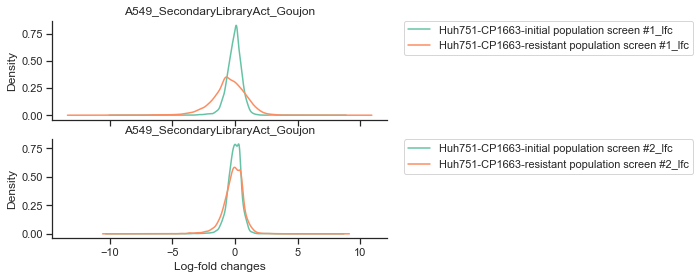

In [31]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[3:])
pDNA_lfc = fns.calculate_lfc(lognorms,target_cols)
pDNA_lfc
pair1 = list(pDNA_lfc.columns[2:4])
pair2 = list(pDNA_lfc.columns[4:])
paired_cols = (True, [pair1, pair2])
#Plot population distributions of log-fold changes 
fns.lfc_dist_plot(pDNA_lfc, paired_cols=paired_cols, filename = 'A549_SecondaryLibraryAct_Goujon')


### Distributions of control sets 

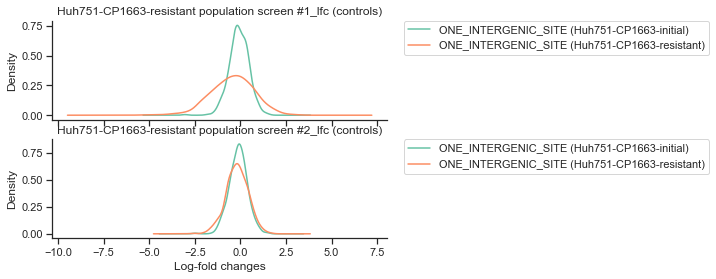

In [32]:
fns.control_dist_plot(pDNA_lfc, paired_cols=paired_cols, control_name=['ONE_INTERGENIC_SITE'], filename = 'A549_SecondaryLibraryAct_Goujon')


### ROC_AUC

Essential gene set: Hart et al., 2015 
<br>
Non-essential gene set: Hart et al., 2014 
<br>
AUC expected to be ~0.5 because no cutting occurred

Text(0, 0.5, 'True Positive Rate (essential)')

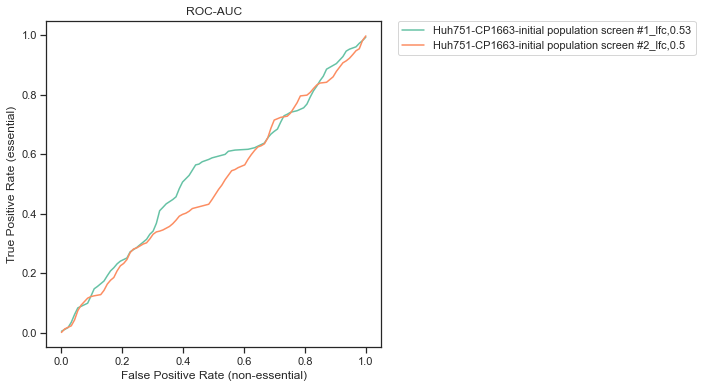

In [33]:
ess_genes, non_ess_genes = fns.get_gene_sets()
initial_cols = [col for col in pDNA_lfc.columns if 'initial' in col]

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

initial_roc_dict = {}
intial_roc_auc_dict = {}
for col in initial_cols:
    roc_auc, roc_df = pool.get_roc_aucs(pDNA_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col=col)
    initial_roc_dict[col] = roc_df
    intial_roc_auc_dict[col] = roc_auc

fig,ax=plt.subplots(figsize=(6,6))

for key, df in initial_roc_dict.items():
    roc_auc = intial_roc_auc_dict[key]
    ax=sns.lineplot(data=df, x='fpr',y='tpr', ci=None, label = key+',' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene level analysis

### Residual z-scores

In [34]:
lfc_df = pDNA_lfc.drop('Gene Symbol', axis = 1)
lfc_df

,Construct Barcode,Huh751-CP1663-initial population screen #1_lfc,Huh751-CP1663-resistant population screen #1_lfc,Huh751-CP1663-initial population screen #2_lfc,Huh751-CP1663-resistant population screen #2_lfc
0,AAAAAAAAAAAAAATTGGCC,-1.080680,-0.849545,-0.527226,-0.701726
1,AAAAAAAAAAAAAATTGGCC,-1.080680,-0.849545,-0.527226,-0.701726
2,AAAAAAAAATTGGCCAGGCG,0.116296,-0.802387,-0.404743,0.060459
3,AAAAAAAGTTGTGCGAGCGA,-0.085890,-0.095592,-0.535542,-0.594424
4,AAAAAAGAAAATAAGTTCCC,-0.343861,1.786470,-0.987883,-1.357498
...,...,...,...,...,...
5847,TTTGGAGTGATATTCGAACA,-0.304405,0.846513,-0.244856,-0.200126
5848,TTTGGCAGTCTATTACGGTA,-0.056021,0.533194,-0.295957,-0.326875
5849,TTTGGTGTGGCCGTCGCGCA,-0.215448,-0.423821,0.163219,-0.174586
5850,TTTGTGGGCCATTTAATTCA,0.739546,-0.050964,0.550449,0.492034


In [35]:
# run_guide_residuals(lfc_df.drop_duplicates(), cols)
residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_df, paired_lfc_cols=paired_cols[1])
residuals_lfcs


                                           modified  \
0  Huh751-CP1663-resistant population screen #1_lfc   
1  Huh751-CP1663-resistant population screen #2_lfc   

                                      unperturbed  
0  Huh751-CP1663-initial population screen #1_lfc  
1  Huh751-CP1663-initial population screen #2_lfc  


,Construct Barcode,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAAAAAAAATTGGCC,Huh751-CP1663-resistant population screen #1_lfc,1.343663,1.480098,Huh751-CP1663-initial population screen #1_lfc,-0.849545,-1.080680
1,AAAAAAAAATTGGCCAGGCG,Huh751-CP1663-resistant population screen #1_lfc,-0.673193,-0.741549,Huh751-CP1663-initial population screen #1_lfc,-0.802387,0.116296
2,AAAAAAAGTTGTGCGAGCGA,Huh751-CP1663-resistant population screen #1_lfc,0.388523,0.427973,Huh751-CP1663-initial population screen #1_lfc,-0.095592,-0.085890
3,AAAAAAGAAAATAAGTTCCC,Huh751-CP1663-resistant population screen #1_lfc,2.728742,3.005818,Huh751-CP1663-initial population screen #1_lfc,1.786470,-0.343861
4,AAAAAAGTTGTGCGAGCGAC,Huh751-CP1663-resistant population screen #1_lfc,0.784609,0.864278,Huh751-CP1663-initial population screen #1_lfc,-0.750444,-0.686545
...,...,...,...,...,...,...,...
9997,TTTGGAGTGATATTCGAACA,Huh751-CP1663-resistant population screen #2_lfc,0.159981,0.300925,Huh751-CP1663-initial population screen #2_lfc,-0.200126,-0.244856
9998,TTTGGCAGTCTATTACGGTA,Huh751-CP1663-resistant population screen #2_lfc,0.087955,0.165444,Huh751-CP1663-initial population screen #2_lfc,-0.326875,-0.295957
9999,TTTGGTGTGGCCGTCGCGCA,Huh751-CP1663-resistant population screen #2_lfc,-0.250612,-0.471404,Huh751-CP1663-initial population screen #2_lfc,-0.174586,0.163219
10000,TTTGTGGGCCATTTAATTCA,Huh751-CP1663-resistant population screen #2_lfc,0.003523,0.006626,Huh751-CP1663-initial population screen #2_lfc,0.492034,0.550449


In [36]:
guide_mapping = pool.group_pseudogenes(chip[['Construct Barcode', 'Gene Symbol']], pseudogene_size=10, gene_col='Gene Symbol', control_regex=['ONE_INTERGENIC_SITE'])
guide_mapping

,Construct Barcode,Gene Symbol
0,AAAAAAAAAAAAAATTGGCC,IQCN
1,AAAAAAAAAAAAAATTGGCC,LOC101929974
2,AAAAAAAAATTGGCCAGGCG,IQCN
3,AAAAAAAGTTGTGCGAGCGA,GDI2
4,AAAAAAGAAAATAAGTTCCC,DBR1
...,...,...
5847,TTTGGAGTGATATTCGAACA,ONE_INTERGENIC_SITE_10
5848,TTTGGCAGTCTATTACGGTA,ONE_INTERGENIC_SITE_43
5849,TTTGGTGTGGCCGTCGCGCA,LYN
5850,TTTGTGGGCCATTTAATTCA,EEF1B2


In [37]:
gene_residuals = anchors.get_gene_residuals(residuals_lfcs.drop_duplicates(), guide_mapping)
gene_residuals

,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,Huh751-CP1663-resistant population screen #1_lfc,ABHD17B,1,-0.290886,-0.108120,0.256432,7.976174e-01,9.297781e-01
1,Huh751-CP1663-resistant population screen #1_lfc,ABRACL,10,0.027881,0.191261,0.262247,7.931309e-01,9.277708e-01
2,Huh751-CP1663-resistant population screen #1_lfc,ACADSB,20,-0.296363,-0.122889,1.303811,1.922980e-01,7.125320e-01
3,Huh751-CP1663-resistant population screen #1_lfc,ACE,10,0.008682,0.253335,0.006268,9.949990e-01,9.959058e-01
4,Huh751-CP1663-resistant population screen #1_lfc,ACE2,10,-3.441768,-0.043240,-10.483002,1.034080e-25,8.479453e-23
...,...,...,...,...,...,...,...,...
1635,Huh751-CP1663-resistant population screen #2_lfc,ZNF626,1,0.639955,0.708783,-0.031721,9.746943e-01,9.891700e-01
1636,Huh751-CP1663-resistant population screen #2_lfc,ZNF703,10,0.092880,0.149237,0.190325,8.490543e-01,9.329920e-01
1637,Huh751-CP1663-resistant population screen #2_lfc,ZNF780A,10,-0.074016,0.103323,-0.502683,6.151871e-01,8.642818e-01
1638,Huh751-CP1663-resistant population screen #2_lfc,ZNF805,10,-0.067479,-0.037796,0.432171,6.656174e-01,8.642818e-01


In [38]:
gene_residual_sheet = fns.format_gene_residuals(gene_residuals, guide_min = 8, guide_max = 11, ascending=True)

guide_residual_sheet = pd.merge(guide_mapping, residuals_lfcs.drop_duplicates(), on = 'Construct Barcode', how = 'inner')
guide_residual_sheet

['Huh751-CP1663-resistant population screen #2_lfc', 'Huh751-CP1663-resistant population screen #1_lfc']
Huh751-CP1663-resistant population screen #2_lfc
Huh751-CP1663-resistant population screen #1_lfc


,Construct Barcode,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAAAAAAAATTGGCC,IQCN,Huh751-CP1663-resistant population screen #1_lfc,1.343663,1.480098,Huh751-CP1663-initial population screen #1_lfc,-0.849545,-1.080680
1,AAAAAAAAAAAAAATTGGCC,IQCN,Huh751-CP1663-resistant population screen #2_lfc,-0.038952,-0.073269,Huh751-CP1663-initial population screen #2_lfc,-0.701726,-0.527226
2,AAAAAAAAAAAAAATTGGCC,LOC101929974,Huh751-CP1663-resistant population screen #1_lfc,1.343663,1.480098,Huh751-CP1663-initial population screen #1_lfc,-0.849545,-1.080680
3,AAAAAAAAAAAAAATTGGCC,LOC101929974,Huh751-CP1663-resistant population screen #2_lfc,-0.038952,-0.073269,Huh751-CP1663-initial population screen #2_lfc,-0.701726,-0.527226
4,AAAAAAAAATTGGCCAGGCG,IQCN,Huh751-CP1663-resistant population screen #1_lfc,-0.673193,-0.741549,Huh751-CP1663-initial population screen #1_lfc,-0.802387,0.116296
...,...,...,...,...,...,...,...,...
11699,TTTGGTGTGGCCGTCGCGCA,LYN,Huh751-CP1663-resistant population screen #2_lfc,-0.250612,-0.471404,Huh751-CP1663-initial population screen #2_lfc,-0.174586,0.163219
11700,TTTGTGGGCCATTTAATTCA,EEF1B2,Huh751-CP1663-resistant population screen #1_lfc,-0.885998,-0.975963,Huh751-CP1663-initial population screen #1_lfc,-0.050964,0.739546
11701,TTTGTGGGCCATTTAATTCA,EEF1B2,Huh751-CP1663-resistant population screen #2_lfc,0.003523,0.006626,Huh751-CP1663-initial population screen #2_lfc,0.492034,0.550449
11702,TTTGTTTAAATAGCACTACA,OR8K5,Huh751-CP1663-resistant population screen #1_lfc,-0.387849,-0.427231,Huh751-CP1663-initial population screen #1_lfc,-1.312762,-0.333998


In [16]:
# with pd.ExcelWriter('../../../Data/Processed/GEO_submission_v2/SecondaryLibrary/Huh751_SecondaryLibraryAct_Goujon.xlsx') as writer:  
#     gene_residual_sheet.to_excel(writer, sheet_name='Huh751_avg_zscore', index =False)
#     reads.to_excel(writer, sheet_name='Huh751_genomewide_reads', index =False)
#     guide_mapping.to_excel(writer, sheet_name='Huh751_guide_mapping', index =False)

In [17]:
# with pd.ExcelWriter('../../../Data/Processed/Individual_screens_v2/SecondaryLibraryIndivScreens/Huh751_SecondaryLibraryAct_Goujon.xlsx') as writer:  
#     gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
#     guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)

### Huh-7.5.1 Act Replicate Correlations

In [39]:
Huh751_screen1_df = gene_residuals[gene_residuals['condition'].str.contains('#1')]
Huh751_screen2_df = gene_residuals[gene_residuals['condition'].str.contains('#2')]
Huh751_zscore_df = pd.merge(Huh751_screen1_df[['Gene Symbol', 'residual_zscore']], Huh751_screen2_df[['Gene Symbol', 'residual_zscore']], on = 'Gene Symbol', how = 'outer', suffixes = ['_screen#1', '_screen#2'])
Huh751_zscore_df

,Gene Symbol,residual_zscore_screen#1,residual_zscore_screen#2
0,ABHD17B,0.256432,1.719474
1,ABRACL,0.262247,-0.351625
2,ACADSB,1.303811,0.585157
3,ACE,0.006268,-0.703293
4,ACE2,-10.483002,-12.877193
...,...,...,...
815,ZNF626,-1.073588,-0.031721
816,ZNF703,2.975691,0.190325
817,ZNF780A,-0.939889,-0.502683
818,ZNF805,0.469337,0.432171


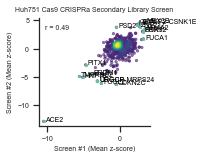

In [40]:
# Screen 2 vs Screen 1

fig, ax = plt.subplots(figsize = (2, 2))
ax = gpp.point_densityplot(Huh751_zscore_df, 'residual_zscore_screen#1', 'residual_zscore_screen#2', s=6)
ax = gpp.add_correlation(Huh751_zscore_df, 'residual_zscore_screen#1', 'residual_zscore_screen#2', fontsize=7)

top_ranked_screen1 = Huh751_zscore_df.nsmallest(5, 'residual_zscore_screen#1')
top_ranked_screen2 = Huh751_zscore_df.nsmallest(5, 'residual_zscore_screen#2')
bottom_ranked_screen1 = Huh751_zscore_df.nlargest(5, 'residual_zscore_screen#1')
bottom_ranked_screen2 = Huh751_zscore_df.nlargest(5, 'residual_zscore_screen#2')

screen1_ranked = pd.concat([top_ranked_screen1, bottom_ranked_screen1])
screen2_ranked = pd.concat([top_ranked_screen2, bottom_ranked_screen2])
ranked = pd.concat([screen1_ranked, screen2_ranked]).drop_duplicates()

# Annotate common hits
# common_ranked = pd.merge(screen1_ranked, screen2_ranked, on = ['Gene Symbol', 'residual_zscore_screen#1', 'residual_zscore_screen#2'], how = 'inner')
# common_ranked

sns.scatterplot(data=ranked, x='residual_zscore_screen#1', y='residual_zscore_screen#2', color = sns.color_palette('Set2')[0], edgecolor=None, s=6)

texts= []
for j, row in ranked.iterrows():
    texts.append(ax.text(row['residual_zscore_screen#1']+0.25, row['residual_zscore_screen#2'], row['Gene Symbol'], fontsize=7,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

plt.title('Huh751 Cas9 CRISPRa Secondary Library Screen', fontsize=7)
plt.xlabel('Screen #1 (Mean z-score)', fontsize=7)
plt.ylabel('Screen #2 (Mean z-score)', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
sns.despine()
# gpp.savefig('../../../Figures/Scatterplots/Huh751_Cas9_Act_Secondary_Screen1vs2_scatterplot.pdf', dpi=300)



### Primary KO vs Cas9 Secondary Huh-7.5.1 Act screens

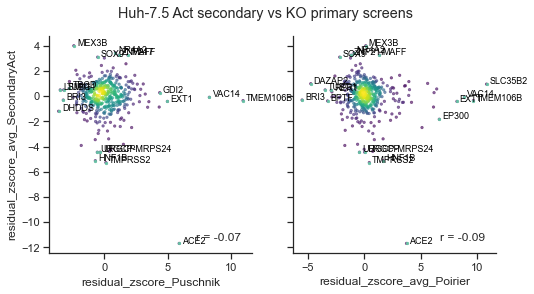

In [43]:
Cas9_KO_Huh7_5_Puschnik_primary = pd.read_excel('../PrimaryScreens/Data/GSE175666_Huh751_GeCKOv2_Puschnik.xlsx')
Cas9_KO_Huh7_5_Poirier_primary = pd.read_excel('../PrimaryScreens/Data/GSE175666_Huh75_Brunello_Poirier_v2.xlsx')

Cas9_KO_Huh7_5_primary = pd.merge(Cas9_KO_Huh7_5_Puschnik_primary, Cas9_KO_Huh7_5_Poirier_primary, on = 'Gene Symbol', how = 'outer')

Cas9_KO_Huh7_5_primary = Cas9_KO_Huh7_5_primary.rename(columns = {'residual_zscore':'residual_zscore_Puschnik',
                                                  'Rank_residual_zscore':'Rank_residual_zscore_Puschnik',
                                                  'residual_zscore_avg':'residual_zscore_avg_Poirier',
                                                  'Rank_residual_zscore_avg':'Rank_residual_zscore_avg_Poirier'})

primaryvssecondary_Huh7_5 = pd.merge(Cas9_KO_Huh7_5_primary, gene_residual_sheet, on = 'Gene Symbol', how = 'inner')
primaryvssecondary_Huh7_5
primaryvssecondary_Huh7_5 = primaryvssecondary_Huh7_5.rename(columns={'residual_zscore_avg':'residual_zscore_avg_SecondaryAct',
                                                                 'Rank_residual_zscore_avg':'Rank_residual_zscore_avg_SecondaryAct'})

fig, axs = plt.subplots(ncols = 2, figsize = (8, 4), sharey=True)

# Puschnik vs Secondary
axs[0] = gpp.point_densityplot(primaryvssecondary_Huh7_5.dropna(), 'residual_zscore_Puschnik', 'residual_zscore_avg_SecondaryAct', s=6, ax = axs[0])
axs[0] = gpp.add_correlation(primaryvssecondary_Huh7_5.dropna(), 'residual_zscore_Puschnik', 'residual_zscore_avg_SecondaryAct', loc = 'lower right', ax = axs[0])
axs[0].set_xlabel('Puschnik (primary KO, mean z-score)')
axs[0].set_ylabel('Secondary (activation, mean z-score)')


# Poirier vs Secondary
axs[1] = gpp.point_densityplot(primaryvssecondary_Huh7_5.dropna(), 'residual_zscore_avg_Poirier', 'residual_zscore_avg_SecondaryAct', s=6, ax = axs[1])
axs[1] = gpp.add_correlation(primaryvssecondary_Huh7_5.dropna(), 'residual_zscore_avg_Poirier', 'residual_zscore_avg_SecondaryAct', loc = 'lower right', ax = axs[1])
axs[1].set_xlabel('Poirier (primary KO, mean z-score)')
axs[1].set_ylabel('Secondary (act, mean z-score)')

# Select top 5 resistance and sensitization hits from each screen
top_ranked_Puschnik = primaryvssecondary_Huh7_5.nlargest(5, 'residual_zscore_Puschnik')
bottom_ranked_Puschnik = primaryvssecondary_Huh7_5.nsmallest(5, 'residual_zscore_Puschnik')
top_ranked_Poirier = primaryvssecondary_Huh7_5.nlargest(5, 'residual_zscore_avg_Poirier')
bottom_ranked_Poirier = primaryvssecondary_Huh7_5.nsmallest(5, 'residual_zscore_avg_Poirier')
top_ranked_SecondaryAct = primaryvssecondary_Huh7_5.nlargest(5, 'residual_zscore_avg_SecondaryAct')
bottom_ranked_SecondaryAct = primaryvssecondary_Huh7_5.nsmallest(5, 'residual_zscore_avg_SecondaryAct')

Puschnik_ranked = pd.concat([top_ranked_Puschnik, bottom_ranked_Puschnik])
Poirier_ranked = pd.concat([top_ranked_Poirier, bottom_ranked_Poirier])
SecondaryAct_ranked = pd.concat([top_ranked_SecondaryAct, bottom_ranked_SecondaryAct])

# Annotate hits
annot_df_Puschnik = pd.concat([Puschnik_ranked, SecondaryAct_ranked]).drop_duplicates()
sns.scatterplot(data=annot_df_Puschnik, x='residual_zscore_Puschnik', y='residual_zscore_avg_SecondaryAct', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, rasterized=True, ax=axs[0])

texts= []
for j, row in annot_df_Puschnik.iterrows():
    texts.append(axs[0].text(row['residual_zscore_Puschnik']+0.25, row['residual_zscore_avg_SecondaryAct'], row['Gene Symbol'], fontsize=9,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

annot_df_Poirier = pd.concat([Poirier_ranked, SecondaryAct_ranked]).drop_duplicates()
sns.scatterplot(data=annot_df_Poirier, x='residual_zscore_avg_Poirier', y='residual_zscore_avg_SecondaryAct', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, rasterized=True, ax=axs[1])

texts= []
for j, row in annot_df_Poirier.iterrows():
    texts.append(axs[1].text(row['residual_zscore_avg_Poirier']+0.25, row['residual_zscore_avg_SecondaryAct'], row['Gene Symbol'], fontsize=9,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

plt.suptitle('Huh-7.5 Act secondary vs KO primary screens')
sns.despine()
# # fig.savefig('../../../Figures/Scatterplots/Calu3_KO_Cas9PrimaryvsCas12aSecondary_scatterplot.png', bbox_inches = 'tight', dpi=300)
# gpp.savefig('../../../Figures/Scatterplots/Huh7_5_KOPrimaryvsActSecondary_scatterplot.pdf', dpi=300)




In [21]:
# with pd.ExcelWriter('../../../Data/Processed/Individual_screens_v2/Calu3_SecondaryLibraryKO_Goujon_indiv_screens.xlsx') as writer:  
#     zscore_df.to_excel(writer, sheet_name='indiv_screen_zscore', index =False)
#     gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
#     guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)

# Secondary Activation Screen comparison

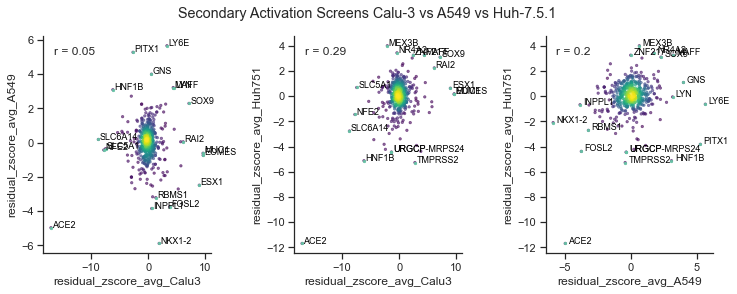

In [45]:
# Read in processed z-scores for all secondary activation screens
Calu3_Secondary_Act = pd.read_excel('Data/GSE193834_Supplemental_File_16_Calu-3_Act_SecondaryLibrary_Goujon.xlsx')
A549_Secondary_Act = pd.read_excel('Data/GSE193834_Supplemental_File_13_A549-ACE2_Act_SecondaryLibrary_Goujon.xlsx')
Huh751_Secondary_Act = pd.read_excel('Data/GSE193834_Supplemental_File_14_Huh7.5.1-ACE2_Act_SecondaryLibrary_Goujon.xlsx')

Calu3_Secondary_Act = Calu3_Secondary_Act.rename(columns = {'residual_zscore_avg':'residual_zscore_avg_Calu3',
                                                           'Rank_residual_zscore_avg':'Rank_residual_zscore_avg_Calu3'})

SecondaryAct = pd.merge(Calu3_Secondary_Act, 
                        pd.merge(A549_Secondary_Act, Huh751_Secondary_Act, on = 'Gene Symbol', how = 'inner', suffixes = ['_A549', '_Huh751']),
                       on = 'Gene Symbol', how = 'inner')

top_ranked_Calu3 = SecondaryAct.nlargest(5, 'residual_zscore_avg_Calu3')
bottom_ranked_Calu3 = SecondaryAct.nsmallest(5, 'residual_zscore_avg_Calu3')
top_ranked_A549 = SecondaryAct.nlargest(5, 'residual_zscore_avg_A549')
bottom_ranked_A549 = SecondaryAct.nsmallest(5, 'residual_zscore_avg_A549')
top_ranked_Huh751 = SecondaryAct.nlargest(5, 'residual_zscore_avg_Huh751')
bottom_ranked_Huh751 = SecondaryAct.nsmallest(5, 'residual_zscore_avg_Huh751')

Calu3_ranked = pd.concat([top_ranked_Calu3, bottom_ranked_Calu3])
A549_ranked = pd.concat([top_ranked_A549, bottom_ranked_A549])
Huh751_ranked = pd.concat([top_ranked_Huh751, bottom_ranked_Huh751])


fig, axs = plt.subplots(ncols=3, figsize=(12, 4))

# A549 vs Calu-3
gpp.point_densityplot(data = SecondaryAct, x = 'residual_zscore_avg_Calu3', y = 'residual_zscore_avg_A549', s=6, ax = axs[0])
ax = gpp.add_correlation(SecondaryAct.dropna(), 'residual_zscore_avg_Calu3', 'residual_zscore_avg_A549', loc = 'upper left', ax = axs[0])
axs[0].set_xlabel('Calu-3 (Mean z-score)')
axs[0].set_ylabel('A549 (Mean z-score)')

# Annotate
annot_df_Calu3_A549 = pd.concat([Calu3_ranked, A549_ranked]).drop_duplicates()
sns.scatterplot(data=annot_df_Calu3_A549, x='residual_zscore_avg_Calu3', y='residual_zscore_avg_A549', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, rasterized=True, ax=axs[0])

texts= []
for j, row in annot_df_Calu3_A549.iterrows():
    texts.append(axs[0].text(row['residual_zscore_avg_Calu3']+0.25, row['residual_zscore_avg_A549'], row['Gene Symbol'], fontsize=9,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)


# Huh-7.5.1 vs Calu-3
gpp.point_densityplot(data = SecondaryAct, x = 'residual_zscore_avg_Calu3', y = 'residual_zscore_avg_Huh751', s=6, ax = axs[1])
ax = gpp.add_correlation(SecondaryAct.dropna(), 'residual_zscore_avg_Calu3', 'residual_zscore_avg_Huh751', loc = 'upper left', ax = axs[1])
axs[1].set_xlabel('Calu-3 (Mean z-score)')
axs[1].set_ylabel('Huh-7.5.1 (Mean z-score)')

# Annotate
annot_df_Calu3_Huh751 = pd.concat([Calu3_ranked, Huh751_ranked]).drop_duplicates()
sns.scatterplot(data=annot_df_Calu3_Huh751, x='residual_zscore_avg_Calu3', y='residual_zscore_avg_Huh751', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, rasterized=True, ax=axs[1])

texts= []
for j, row in annot_df_Calu3_Huh751.iterrows():
    texts.append(axs[1].text(row['residual_zscore_avg_Calu3']+0.25, row['residual_zscore_avg_Huh751'], row['Gene Symbol'], fontsize=9,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

# Huh-7.5.1 vs A549
gpp.point_densityplot(data = SecondaryAct, x = 'residual_zscore_avg_A549', y = 'residual_zscore_avg_Huh751', s=6, ax = axs[2])
ax = gpp.add_correlation(SecondaryAct.dropna(), 'residual_zscore_avg_A549', 'residual_zscore_avg_Huh751', loc = 'upper left', ax = axs[2])
axs[2].set_xlabel('A549 (Mean z-score)')
axs[2].set_ylabel('Huh-7.5.1 (Mean z-score)')

# Annotate
annot_df_A549_Huh751 = pd.concat([A549_ranked, Huh751_ranked]).drop_duplicates()
sns.scatterplot(data=annot_df_A549_Huh751, x='residual_zscore_avg_A549', y='residual_zscore_avg_Huh751', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, rasterized=True, ax=axs[2])

texts= []
for j, row in annot_df_A549_Huh751.iterrows():
    texts.append(axs[2].text(row['residual_zscore_avg_A549']+0.25, row['residual_zscore_avg_Huh751'], row['Gene Symbol'], fontsize=9,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

sns.despine()
plt.suptitle('Secondary Activation Screens Calu-3 vs A549 vs Huh-7.5.1')
plt.subplots_adjust(wspace=0.5)

# gpp.savefig('../../../Figures/Scatterplots/SecondaryActivationScreenComparison_Calu3A549Huh751.pdf', dpi=300)


## Comparison with Caco-2 CRISPRa

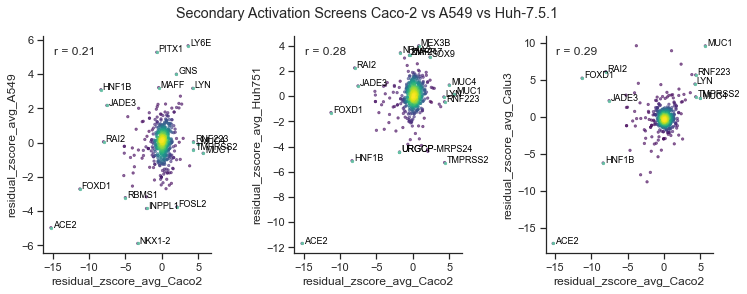

In [46]:
# Read in processed z-scores for all secondary activation screens
Caco2_Secondary_Act = pd.read_excel('Data/GSE193834_Supplemental_File_15_Caco-2-ACE2_Act_SecondaryLibrary_Goujon.xlsx')

Caco2_Secondary_Act = Caco2_Secondary_Act.rename(columns = {'residual_zscore_avg':'residual_zscore_avg_Caco2',
                                                           'Rank_residual_zscore_avg':'Rank_residual_zscore_avg_Caco2'})

SecondaryAct_2 = pd.merge(Caco2_Secondary_Act, SecondaryAct, on = 'Gene Symbol', how = 'inner').dropna()

top_ranked_Caco2 = SecondaryAct_2.nlargest(5, 'residual_zscore_avg_Caco2')
bottom_ranked_Caco2 = SecondaryAct_2.nsmallest(5, 'residual_zscore_avg_Caco2')
top_ranked_A549 = SecondaryAct_2.nlargest(5, 'residual_zscore_avg_A549')
bottom_ranked_A549 = SecondaryAct_2.nsmallest(5, 'residual_zscore_avg_A549')
top_ranked_Huh751 = SecondaryAct_2.nlargest(5, 'residual_zscore_avg_Huh751')
bottom_ranked_Huh751 = SecondaryAct_2.nsmallest(5, 'residual_zscore_avg_Huh751')

Caco2_ranked = pd.concat([top_ranked_Caco2, bottom_ranked_Caco2])
A549_ranked = pd.concat([top_ranked_A549, bottom_ranked_A549])
Huh751_ranked = pd.concat([top_ranked_Huh751, bottom_ranked_Huh751])


fig, axs = plt.subplots(ncols=3, figsize=(12, 4))

# A549 vs Caco-2
gpp.point_densityplot(data = SecondaryAct_2, x = 'residual_zscore_avg_Caco2', y = 'residual_zscore_avg_A549', s=6, ax = axs[0])
ax = gpp.add_correlation(SecondaryAct_2.dropna(), 'residual_zscore_avg_Caco2', 'residual_zscore_avg_A549', loc = 'upper left', ax = axs[0])
axs[0].set_xlabel('Caco-2 (Mean z-score)')
axs[0].set_ylabel('A549 (Mean z-score)')

# Annotate
annot_df_Caco2_A549 = pd.concat([Caco2_ranked, A549_ranked]).drop_duplicates()
sns.scatterplot(data=annot_df_Caco2_A549, x='residual_zscore_avg_Caco2', y='residual_zscore_avg_A549', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, rasterized=True, ax=axs[0])

texts= []
for j, row in annot_df_Caco2_A549.iterrows():
    texts.append(axs[0].text(row['residual_zscore_avg_Caco2']+0.25, row['residual_zscore_avg_A549'], row['Gene Symbol'], fontsize=9,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)


# Huh-7.5.1 vs Caco-2
gpp.point_densityplot(data = SecondaryAct_2, x = 'residual_zscore_avg_Caco2', y = 'residual_zscore_avg_Huh751', s=6, ax = axs[1])
ax = gpp.add_correlation(SecondaryAct_2.dropna(), 'residual_zscore_avg_Caco2', 'residual_zscore_avg_Huh751', loc = 'upper left', ax = axs[1])
axs[1].set_xlabel('Caco-2 (Mean z-score)')
axs[1].set_ylabel('Huh-7.5.1 (Mean z-score)')

# Annotate
annot_df_Caco2_Huh751 = pd.concat([Caco2_ranked, Huh751_ranked]).drop_duplicates()
sns.scatterplot(data=annot_df_Caco2_Huh751, x='residual_zscore_avg_Caco2', y='residual_zscore_avg_Huh751', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, rasterized=True, ax=axs[1])

texts= []
for j, row in annot_df_Caco2_Huh751.iterrows():
    texts.append(axs[1].text(row['residual_zscore_avg_Caco2']+0.25, row['residual_zscore_avg_Huh751'], row['Gene Symbol'], fontsize=9,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

# Calu-3 vs Caco-2
gpp.point_densityplot(data = SecondaryAct_2, x = 'residual_zscore_avg_Caco2', y = 'residual_zscore_avg_Calu3', s=6, ax = axs[2])
ax = gpp.add_correlation(SecondaryAct_2.dropna(), 'residual_zscore_avg_Caco2', 'residual_zscore_avg_Calu3', loc = 'upper left', ax = axs[2])
axs[2].set_xlabel('Caco-2 (Mean z-score)')
axs[2].set_ylabel('Calu-3 (Mean z-score)')

# Annotate
annot_df_Caco2_Calu3 = pd.concat([Caco2_ranked, Calu3_ranked]).drop_duplicates().dropna()
sns.scatterplot(data=annot_df_Caco2_Calu3, x='residual_zscore_avg_Caco2', y='residual_zscore_avg_Calu3', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, rasterized=True, ax=axs[2])

texts= []
for j, row in annot_df_Caco2_Calu3.iterrows():
    texts.append(axs[2].text(row['residual_zscore_avg_Caco2']+0.25, row['residual_zscore_avg_Calu3'], row['Gene Symbol'], fontsize=9,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

sns.despine()
plt.suptitle('Secondary Activation Screens Caco-2 vs A549 vs Huh-7.5.1')
plt.subplots_adjust(wspace=0.5)

# gpp.savefig('../../../Figures/Scatterplots/SecondaryActivationScreenComparison_Caco2A549Huh751Calu3.pdf', dpi=300)


## Heatmap

Text(0.5, 1.0, 'Secondary Activation Sensitization Hits')

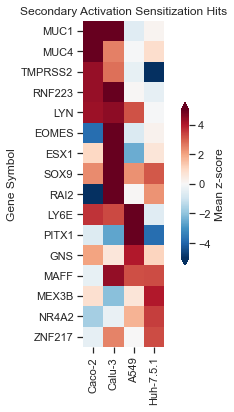

In [47]:
sensitization_heatmap_df = select_top_ranks(SecondaryAct_2)
# sensitization_heatmap_df=sensitization_heatmap_df.sort_values(by=list(sensitization_heatmap_df.columns[1:]), ascending=False)
rank_cols = [col for col in sensitization_heatmap_df.columns if 'Rank' in col]
sensitization_heatmap_df = sensitization_heatmap_df.drop(rank_cols, axis=1)
Secondary_Act_sensitization_heatmap = sensitization_heatmap_df.copy().set_index('Gene Symbol').dropna(axis = 0)

fig, ax = plt.subplots(figsize=(6, 6))

xlabels = ['Caco-2', 'Calu-3', 'A549', 'Huh-7.5.1']

g = sns.heatmap(Secondary_Act_sensitization_heatmap, cmap = gpp.diverging_cmap(), xticklabels=xlabels, yticklabels=True, square=True, vmin=-5, vmax=5, cbar_kws={'shrink':0.5, 'extend':'both', 'label':'Mean z-score'},
               center = 0)
plt.title('Secondary Activation Sensitization Hits')

# gpp.savefig('../../../Figures/Heatmaps/Secondary_Activation_sensitization_heatmap.pdf', dpi=300, bbox_inches = 'tight')
# fig.savefig('../../../Figures/Heatmaps/Secondary_Activation_sensitization_heatmap.png', dpi=300, bbox_inches = 'tight')


Text(0.5, 1.0, 'Secondary Activation Resistance Hits')

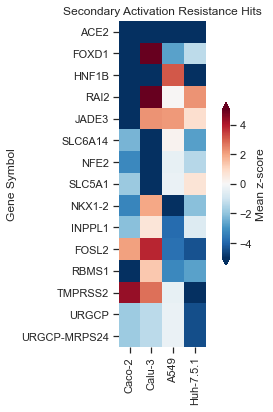

In [48]:
resistance_heatmap_df = select_top_ranks(SecondaryAct_2, largest=False)
# resistance_heatmap_df=resistance_heatmap_df.sort_values(by=list(resistance_heatmap_df.columns[1:]), ascending=False)
rank_cols = [col for col in resistance_heatmap_df.columns if 'Rank' in col]
resistance_heatmap_df = resistance_heatmap_df.drop(rank_cols, axis=1)
Secondary_Act_resistance_heatmap = resistance_heatmap_df.copy().set_index('Gene Symbol').dropna(axis = 0)

fig, ax = plt.subplots(figsize=(6, 6))

xlabels = ['Caco-2', 'Calu-3', 'A549', 'Huh-7.5.1']

g = sns.heatmap(Secondary_Act_resistance_heatmap, cmap = gpp.diverging_cmap(), xticklabels=xlabels, yticklabels=True, square=True, vmin = -5, vmax = 5, cbar_kws={'shrink':0.5, 'label':'Mean z-score', 'extend':'both'},
               center = 0)
plt.title('Secondary Activation Resistance Hits')

# gpp.savefig('../../../Figures/Heatmaps/Secondary_Activation_resistance_heatmap.pdf', dpi=300, bbox_inches = 'tight')
# fig.savefig('../../../Figures/Heatmaps/Secondary_Activation_resistance_heatmap.png', dpi=300, bbox_inches = 'tight')